In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt

from paths import paths

In [16]:
def plot_eeg(df):
    _, axs = plt.subplots(len(df.columns), 1, figsize=(30,15), sharex=True)
    for i, ax in enumerate(axs):
        ax.plot(df.iloc[:, i], color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)

In [17]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):
    ret = {key: [] for key in x.columns}

    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard')
                     for i in coeff[1:])

        ret[pos] = pywt.waverec(coeff, wavelet, mode='per')

    return pd.DataFrame(ret)

In [18]:
print("The mother functions you can use")
print(pywt.wavelist())

The mother functions you can use
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5',

In [19]:
# get eeg signal
df = pd.read_csv(paths.TRAIN_CSV)
row = df.sample(n=1, random_state=60).iloc[0,]
for state in ['seizure', 'grda', 'lrda', 'lpd', 'gpd', 'other']:
    print(state, row[f"{state}_vote"])

seizure 0
grda 2
lrda 0
lpd 0
gpd 0
other 2


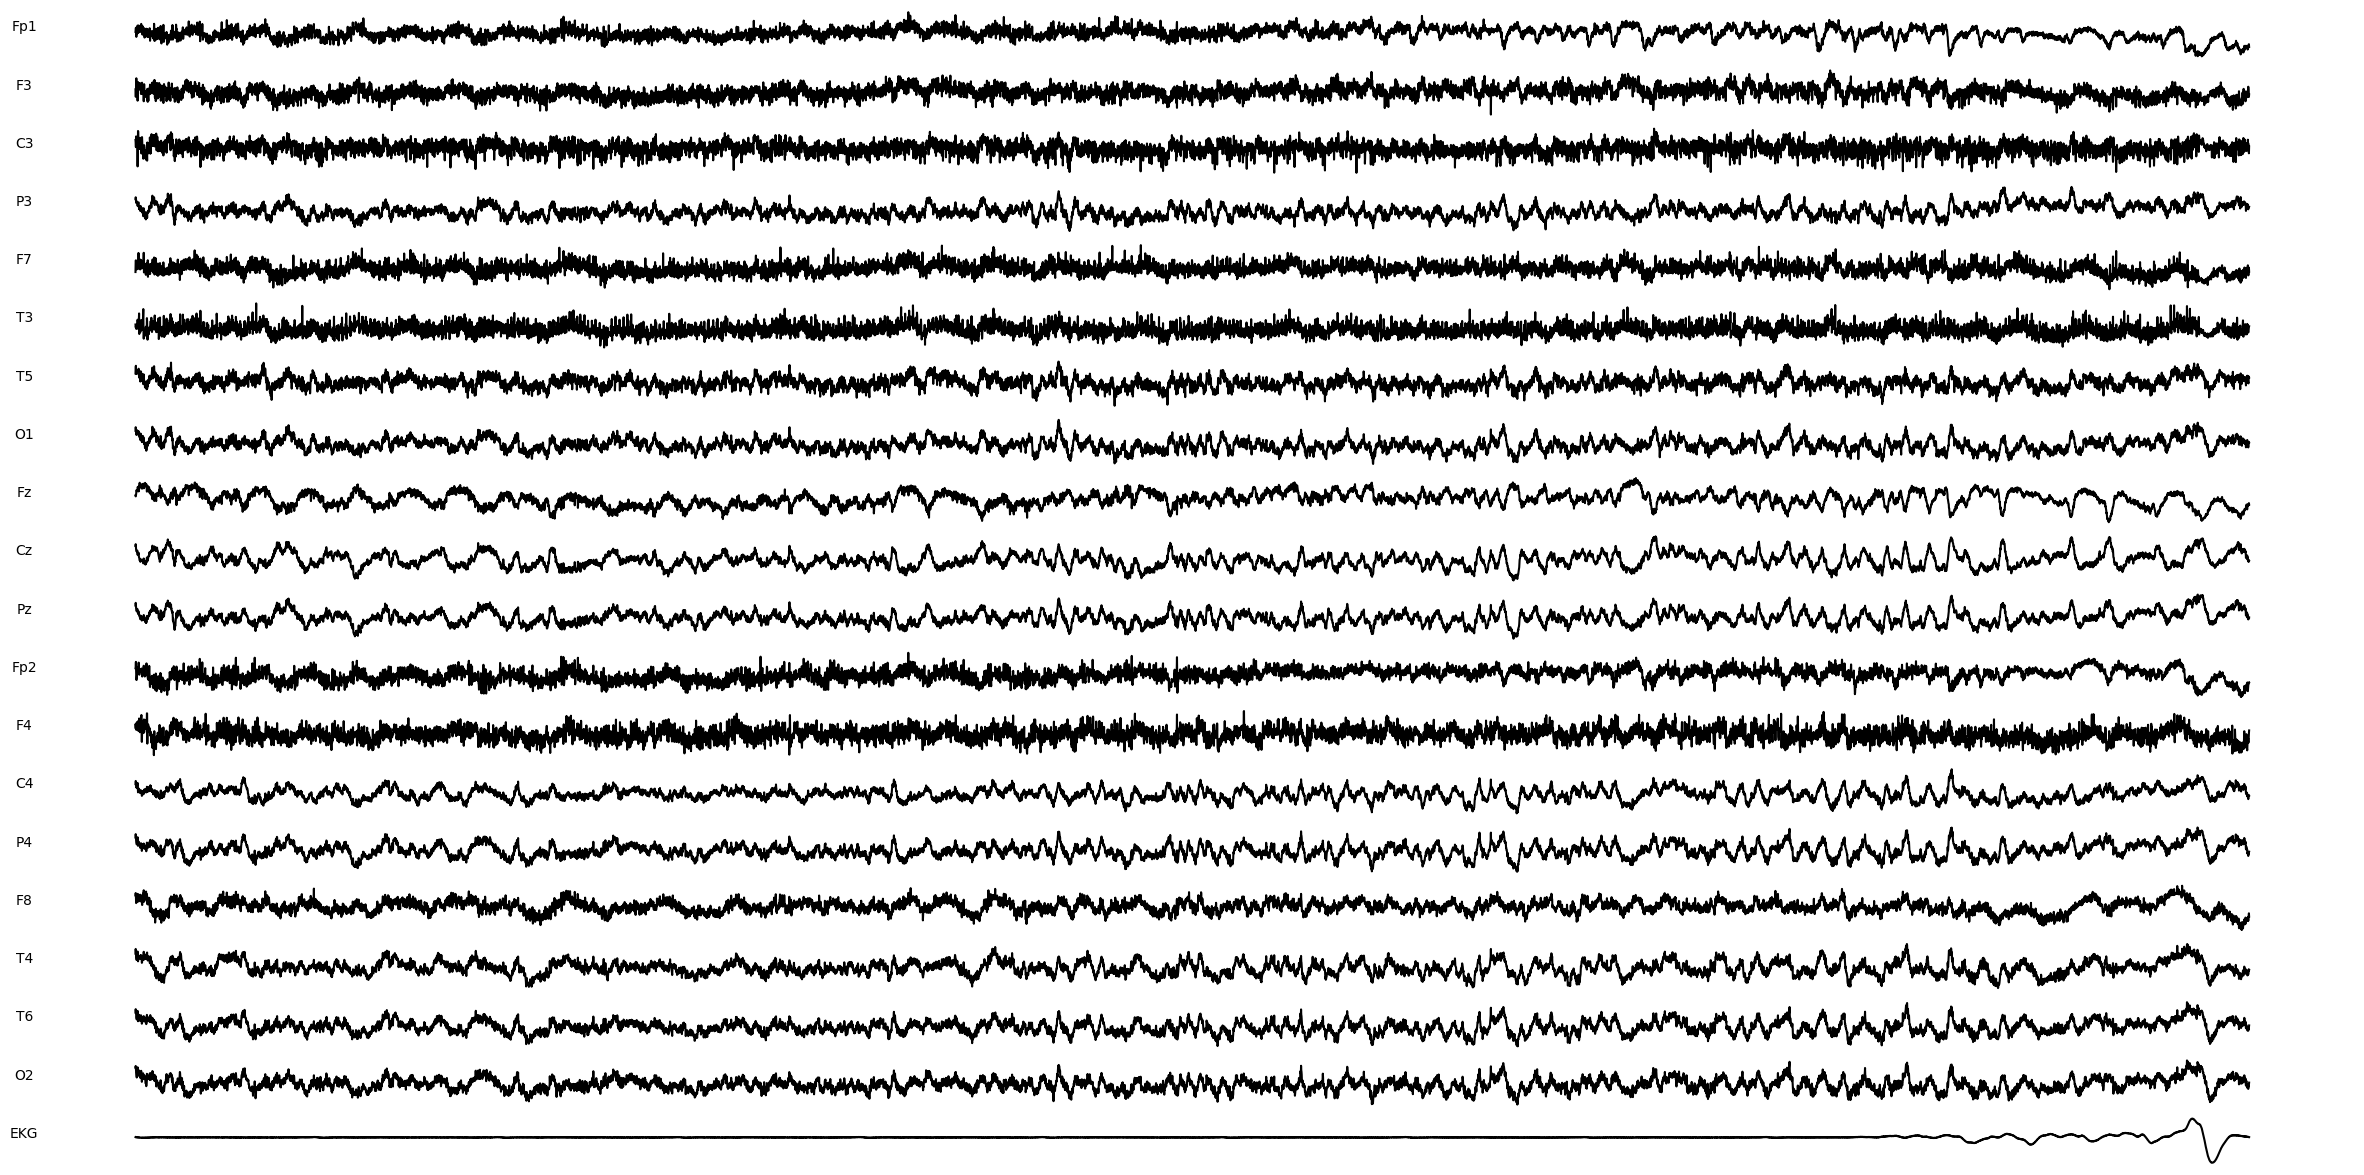

In [20]:
eeg = pd.read_parquet(paths.TRAIN_EEGS+str(row["eeg_id"])+".parquet")
eeg = eeg[int(row["eeg_label_offset_seconds"]) *
          200:int(row["eeg_label_offset_seconds"])*200+50*200]
plot_eeg(eeg)

2000


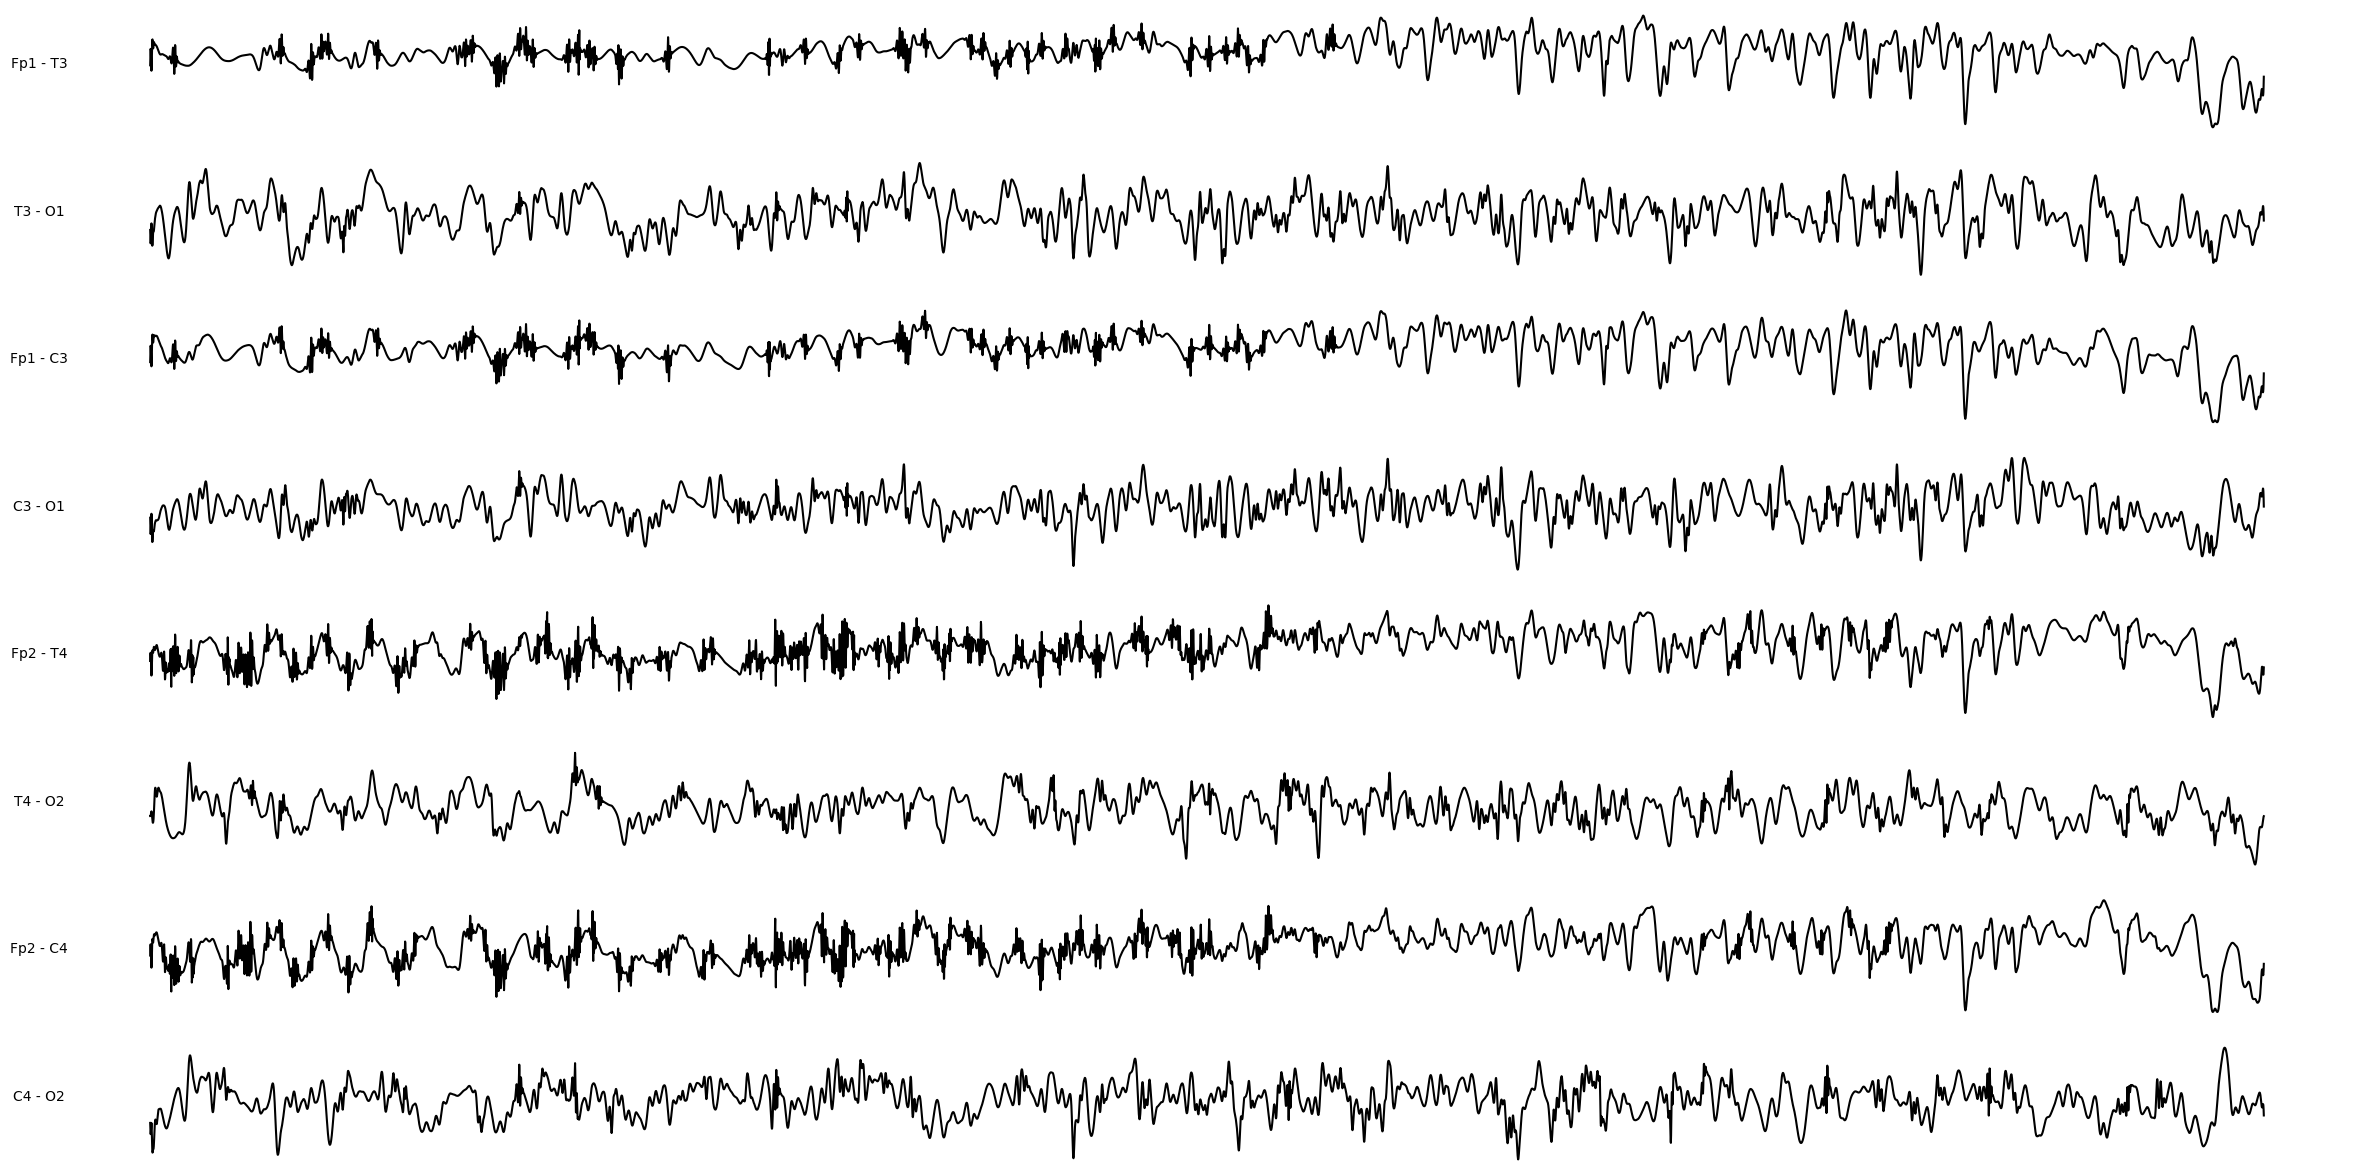

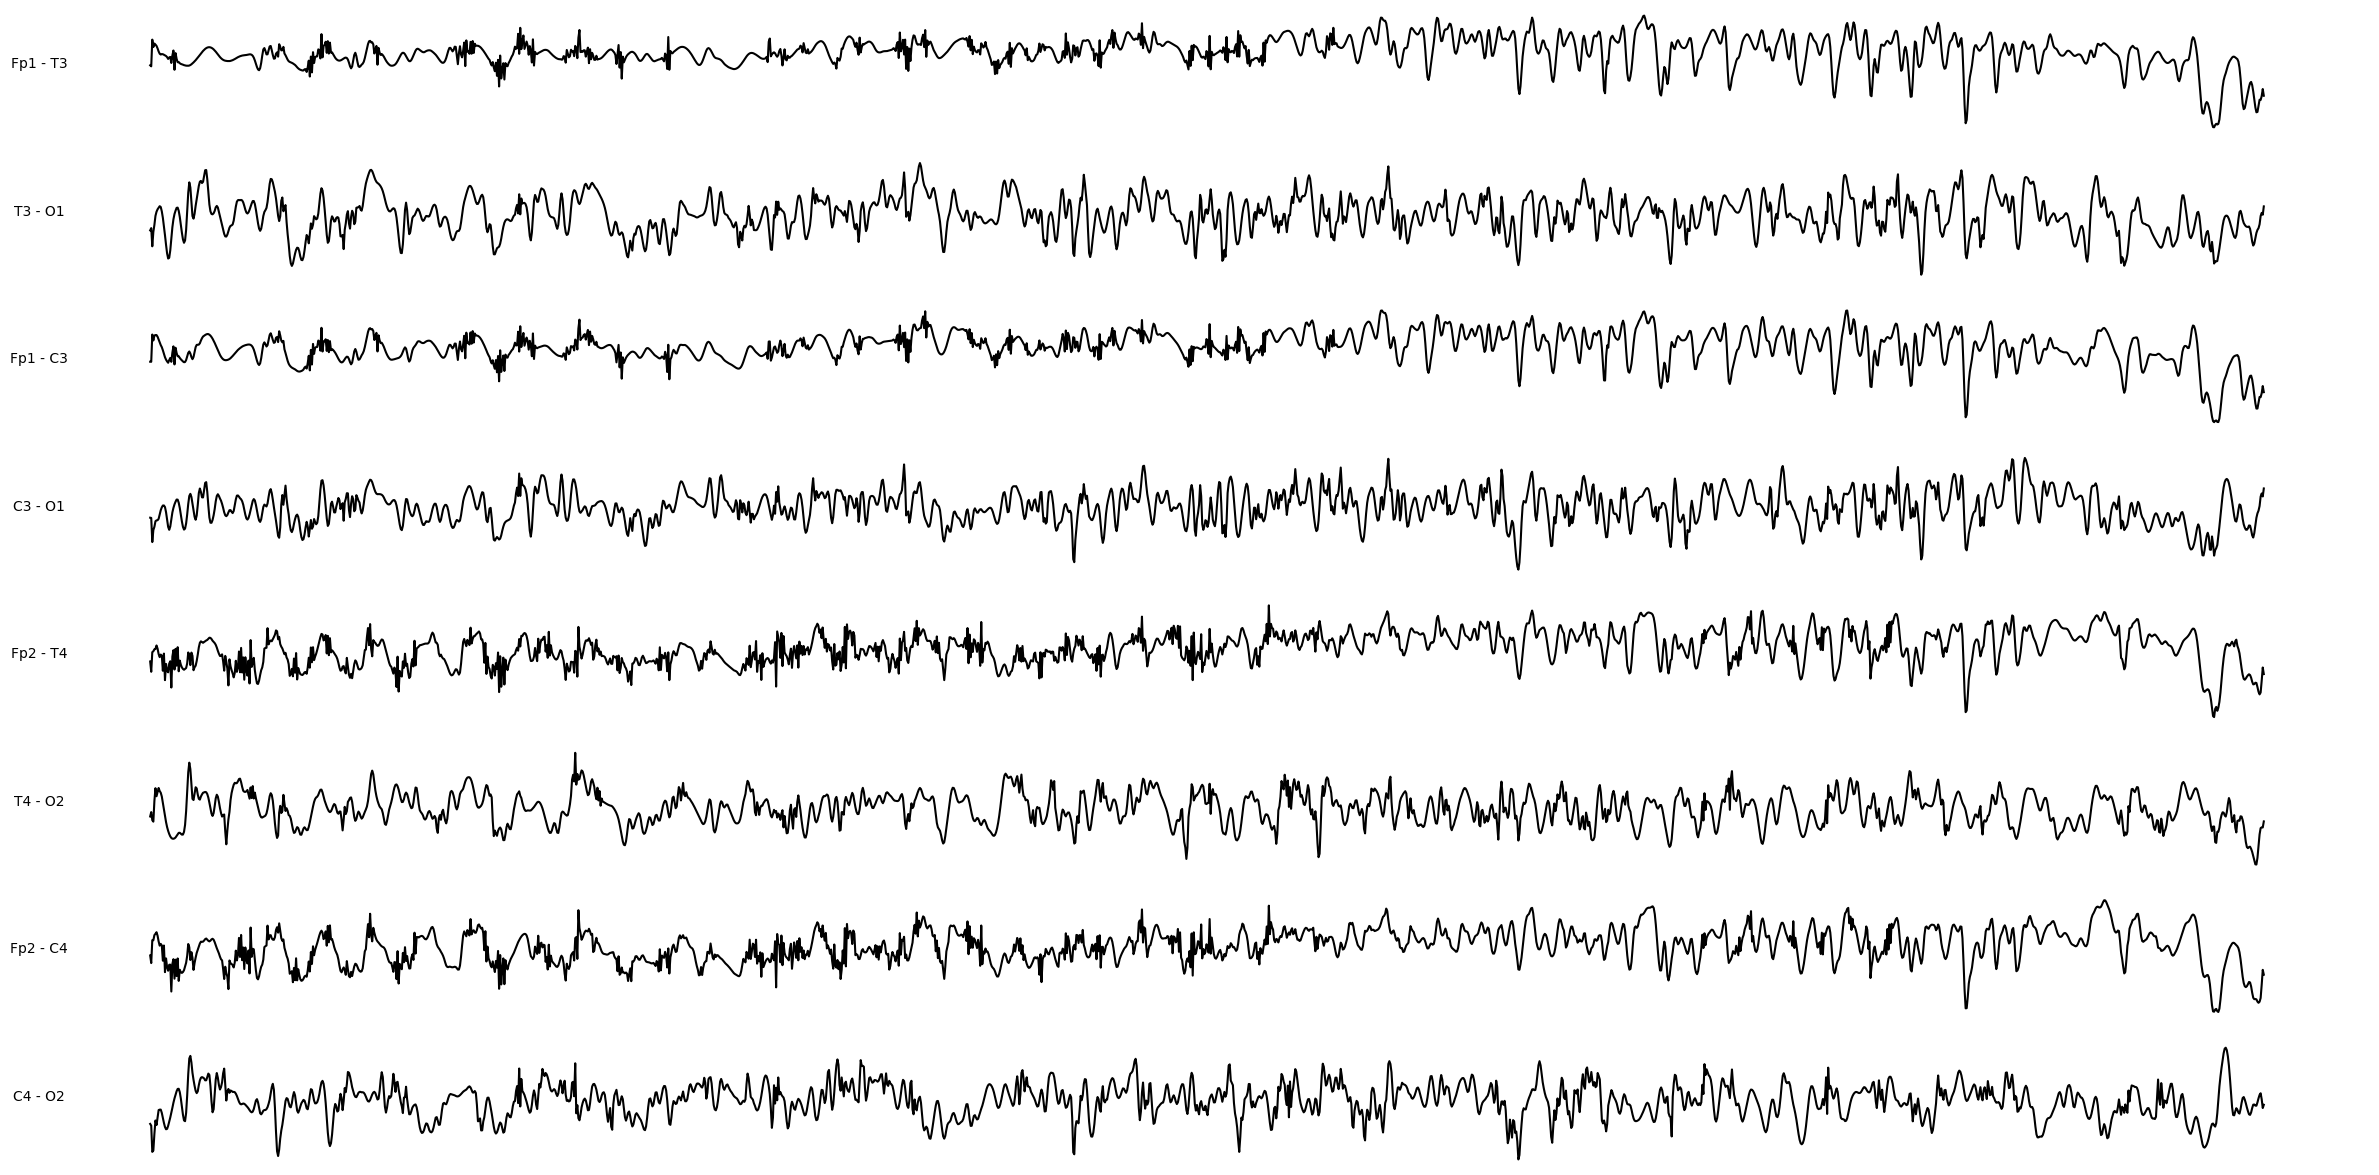

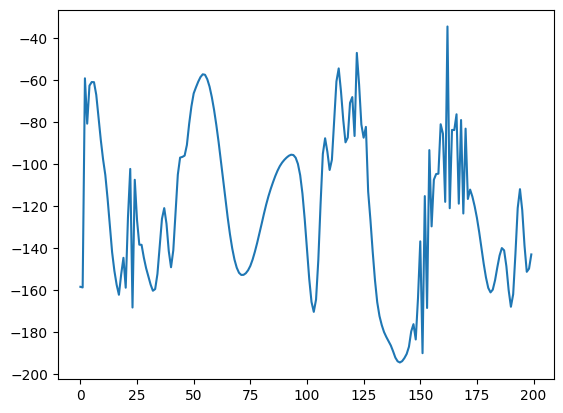

In [21]:
eeg_denoised = denoise(eeg, wavelet="db8")
eeg_fe = pd.DataFrame()
eeg_fe['Fp1 - T3'] = eeg_denoised['Fp1'] - eeg_denoised['T3']
eeg_fe['T3 - O1'] = eeg_denoised['T3'] - eeg_denoised['O1']
eeg_fe['Fp1 - C3'] = eeg_denoised['Fp1'] - eeg_denoised['C3']
eeg_fe['C3 - O1'] = eeg_denoised['C3'] - eeg_denoised['O1']
eeg_fe['Fp2 - T4'] = eeg_denoised['Fp2'] - eeg_denoised['T4']
eeg_fe['T4 - O2'] = eeg_denoised['T4'] - eeg_denoised['O2']
eeg_fe['Fp2 - C4'] = eeg_denoised['Fp2'] - eeg_denoised['C4']
eeg_fe['C4 - O2'] = eeg_denoised['C4'] - eeg_denoised['O2']
plot_eeg(eeg_fe)
eeg_down = eeg_fe.loc[::5,:]
print(len(eeg_down))
plot_eeg(eeg_down)
plt.show()
plt.plot(eeg_down.reset_index()['Fp1 - C3'][0:200])